# Convolutional Networks


- Original authors: Eis Annavini, Alessio Ansuini (SISSA, Trieste)
- Based on Michael Nielsen's [online book 'Neural Networks and Deep Learning'](http://neuralnetworksanddeeplearning.com/)
- Adapted by Chris Mathys

Before you start, set up an environment in which to run this:

```
$ conda create -n tf python=3.7 tensorflow jupyter matplotlib tqdm nomkl
$ conda activate tf
$ conda install -c conda-forge jupyterthemes
```

The `nomkl` module is only required on some Macs to avoid an error on those systems. Now you can start by running

```
$ jupyter notebook
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import os.path as path
import os
import pickle
from tensorflow.keras import backend as K
from tqdm.notebook import tnrange

jtplot.style(grid=False, ticks=True)

# Needed on some Macs without nomkl installed
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def show_test(model, validation_data):
    labels = np.argmax(model.predict(validation_data[0]), axis=1)
    ground_truth = np.argmax(validation_data[1], axis=1)
    accuracy = np.sum(labels != ground_truth)/labels.size
    num_errors = min(np.sum(labels != ground_truth), 20)
    errors = np.random.choice(np.nonzero(labels != ground_truth)[0], num_errors, replace=False)
    correct = np.random.choice(
        np.nonzero(labels == ground_truth)[0], 60 - num_errors, replace=False)
    stimuli = np.hstack((errors, correct))
    np.random.shuffle(stimuli)
    plt.style.use('grayscale')
    num_columns = 10
    num_rows = 6
    fig, axes = plt.subplots(num_rows, 10, figsize=(20, 3 * num_rows))
    for idx, ax in zip(stimuli, axes.ravel()):
        if idx in errors:
            c = 'r'
        else:
            c = 'k'
        ax.matshow(validation_data[0][idx, :, :, 0])
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title('Prediction: '+str(labels[idx])+
                     ' \n Truth: '+str(ground_truth[idx]), color=c)
    plt.suptitle("Model error rate: {:.2f}%".format(accuracy*100))
    plt.show()
    jtplot.style(grid=False, ticks=True)

In [3]:
#help(mnist.load_data)

(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_train, l_test = to_categorical(l_train), to_categorical(l_test)
i_validate = i_train[50000:, :, :, :]
i_train = i_train[0:50000, :, :, :]
l_validate = l_train[50000:, :]
l_train = l_train[0:50000, :]

In [4]:
if not path.isdir('models'):
    os.mkdir('models')

if path.isfile(path.join('models', 'training_hist.pkl')):
    print("Loading training history...")
    with open(path.join('models', 'training_hist.pkl'), 'rb') as f:
        history = pickle.load(f)

Loading training history...


# Fully connected network
----------------------------
<img src="Figures/mlp.png" alt="drawing" width="800" >

In this hands-on session we will expand the network we built to solve the MNIST digit classification problem to include convolutional layers, and we will see how this changes its behaviour and performance.

Let's start by rebuilding the last network we built in yesterday's hands-on session in Keras, and this will form the basis from which to move.

In [5]:
minibatch_size = 10
n_epochs = 2
learn_rate = 0.1
history = {}
tb_params = {
    'write_images': True,
    'histogram_freq': 5,
    'write_graph': False
            }
activation_fcn = 'sigmoid'

In [6]:
# Define architecture
img = layers.Input(shape=(28, 28, 1,), name='images')
x = layers.Flatten()(img)
x = layers.Dense(100, activation=activation_fcn, name='hidden')(x)
out = layers.Dense(10, activation='softmax', name='output')(x)
model = Model(img, out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
print(model.input)

Tensor("images:0", shape=(None, 28, 28, 1), dtype=float32)


In [8]:
print(model.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x10716a748>, <tensorflow.python.keras.layers.core.Flatten object at 0x10716a8d0>, <tensorflow.python.keras.layers.core.Dense object at 0x10716a4e0>, <tensorflow.python.keras.layers.core.Dense object at 0x635c1c908>]


In [9]:
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'fully_connected'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Fully Connected'] = h.history
history['Fully Connected']['epoch'] = h.epoch

model.save(path.join('models', 'fully_connected.h5'))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 20s 402us/sample - loss: 0.3974 - accuracy: 0.8860 - val_loss: 0.2439 - val_accuracy: 0.9287
Epoch 2/2
50000/50000 [==============================] - 15s 310us/sample - loss: 0.2173 - accuracy: 0.9361 - val_loss: 0.1696 - val_accuracy: 0.9523


In [10]:
hist = history['Fully Connected']
hist

{'loss': [0.39739202297274023, 0.21732369562708773],
 'accuracy': [0.88598, 0.93608],
 'val_loss': [0.24385111047839747, 0.16964496949978639],
 'val_accuracy': [0.9287, 0.9523],
 'epoch': [0, 1]}

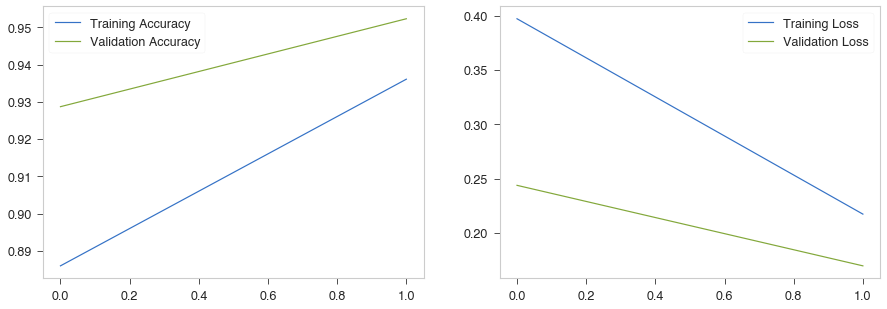

In [11]:
hist = history['Fully Connected']
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['accuracy'])
ax[0].plot(hist['epoch'], hist['val_accuracy'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

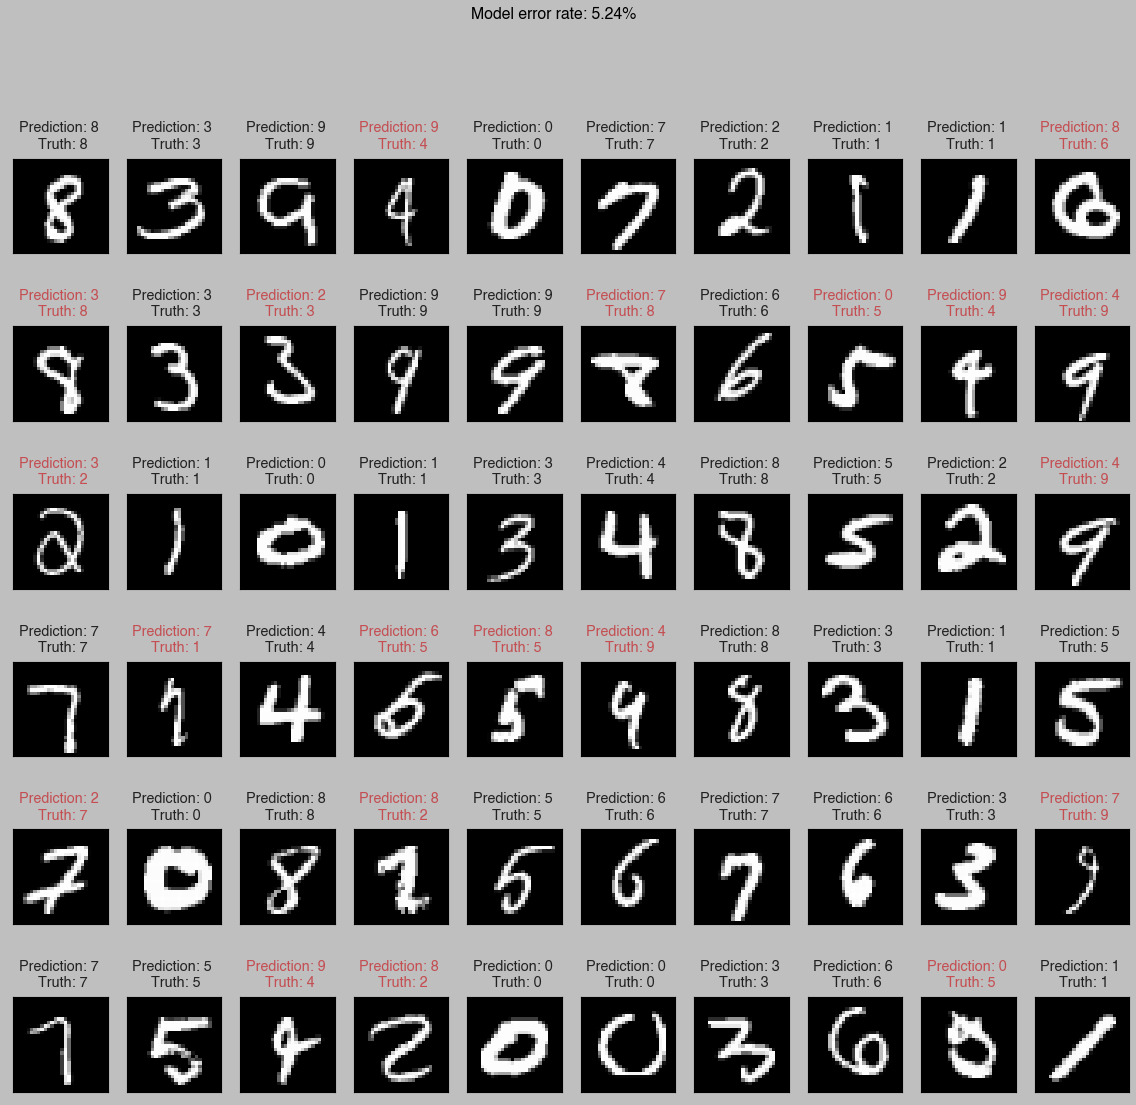

In [12]:
K.clear_session()
model = load_model(path.join('models', 'fully_connected.h5'))
show_test(model, (i_test, l_test))

# Adding a convolutional layer
--------------------------------------------------

<img src="Figures/simple_conv.png" alt="drawing" width="800" >

Now we will begin adding convolutional layers to our network. The syntax is really simple, and the code is quite self-explanatory; as a first step, we will complement our 1 hidden layer network with a single convolutional layer consisting of 20 banks of 5x5 filters followed by 2x2 max-pooling.

In [13]:
K.clear_session()
img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2880)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               288100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 289,630
Trainable params: 289,630
Non-trainable params: 0
_______________________________________________________

In [14]:
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Convolutional'] = h.history
history['Convolutional']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional.h5'))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.6684 - accuracy: 0.7730 - val_loss: 0.2626 - val_accuracy: 0.9204
Epoch 2/2
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.1790 - accuracy: 0.9459 - val_loss: 0.1327 - val_accuracy: 0.9612


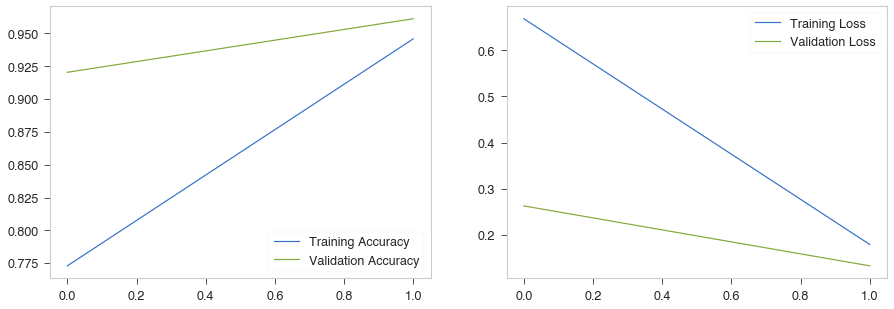

In [15]:
hist = history['Convolutional']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['accuracy'])
ax[0].plot(hist['epoch'], hist['val_accuracy'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

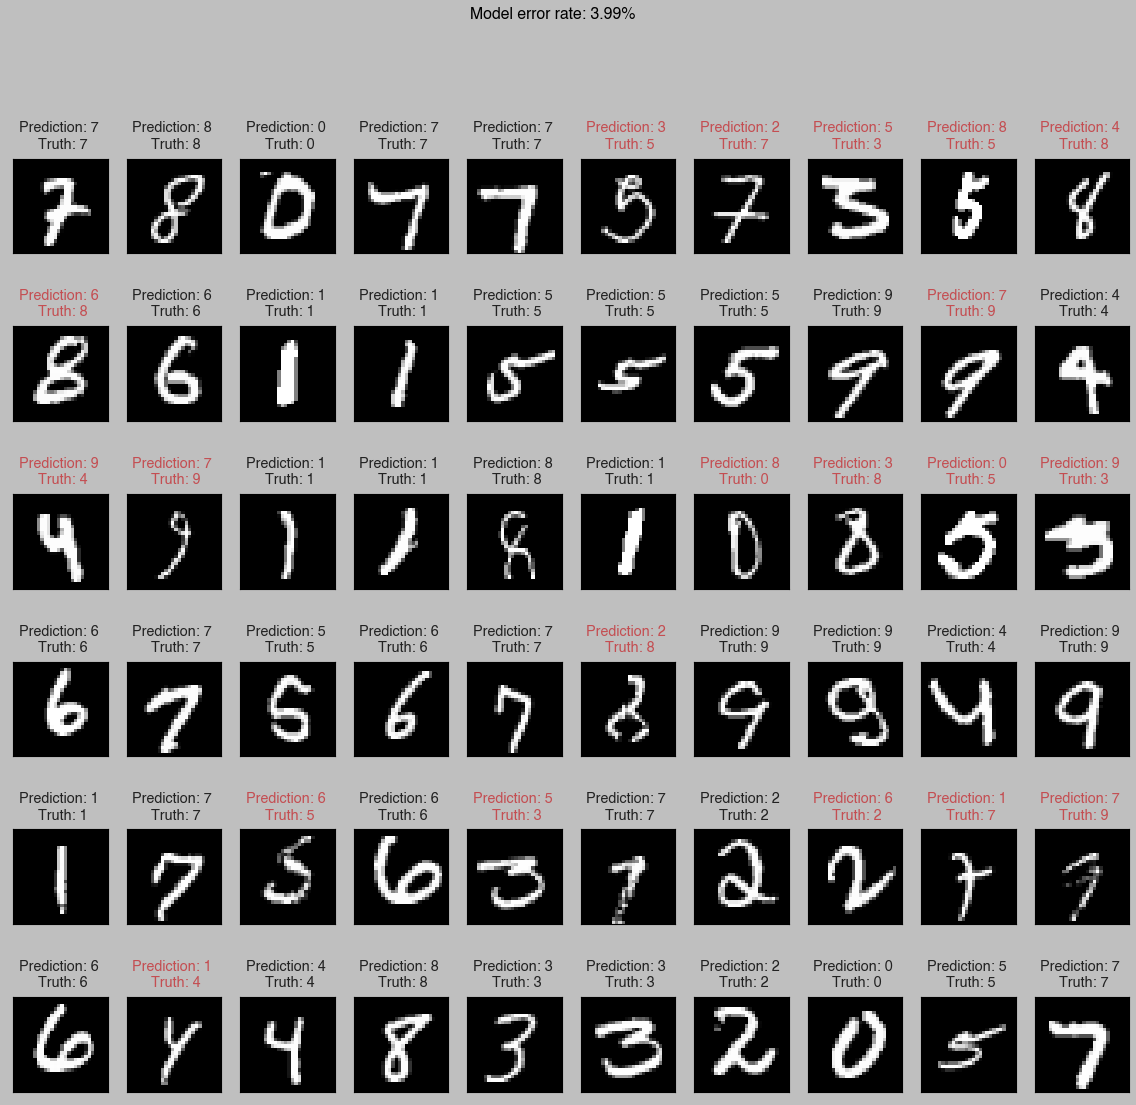

In [16]:
K.clear_session()
model = load_model(path.join('models', 'convolutional.h5'))
show_test(model, (i_test, l_test))

# Adding another convolutional layer

The next step is to add another convolutional layer, that builds more complex features by combining the ones emerging from the previous one. This time we will use 40 banks of 5x5 filters, also followed by 2x2 max-pooling

In [17]:
K.clear_session()
img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               64100 

In [18]:
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_2layers'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Convolutional (2 Layers)'] = h.history
history['Convolutional (2 Layers)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_2layers.h5'))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 118s 2ms/sample - loss: 1.2503 - accuracy: 0.5442 - val_loss: 0.1748 - val_accuracy: 0.9498
Epoch 2/2
50000/50000 [==============================] - 111s 2ms/sample - loss: 0.1400 - accuracy: 0.9580 - val_loss: 0.0924 - val_accuracy: 0.9742


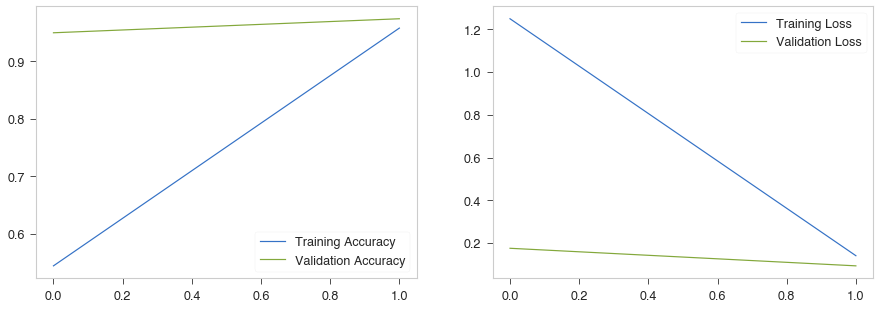

In [19]:
hist = history['Convolutional (2 Layers)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['accuracy'])
ax[0].plot(hist['epoch'], hist['val_accuracy'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

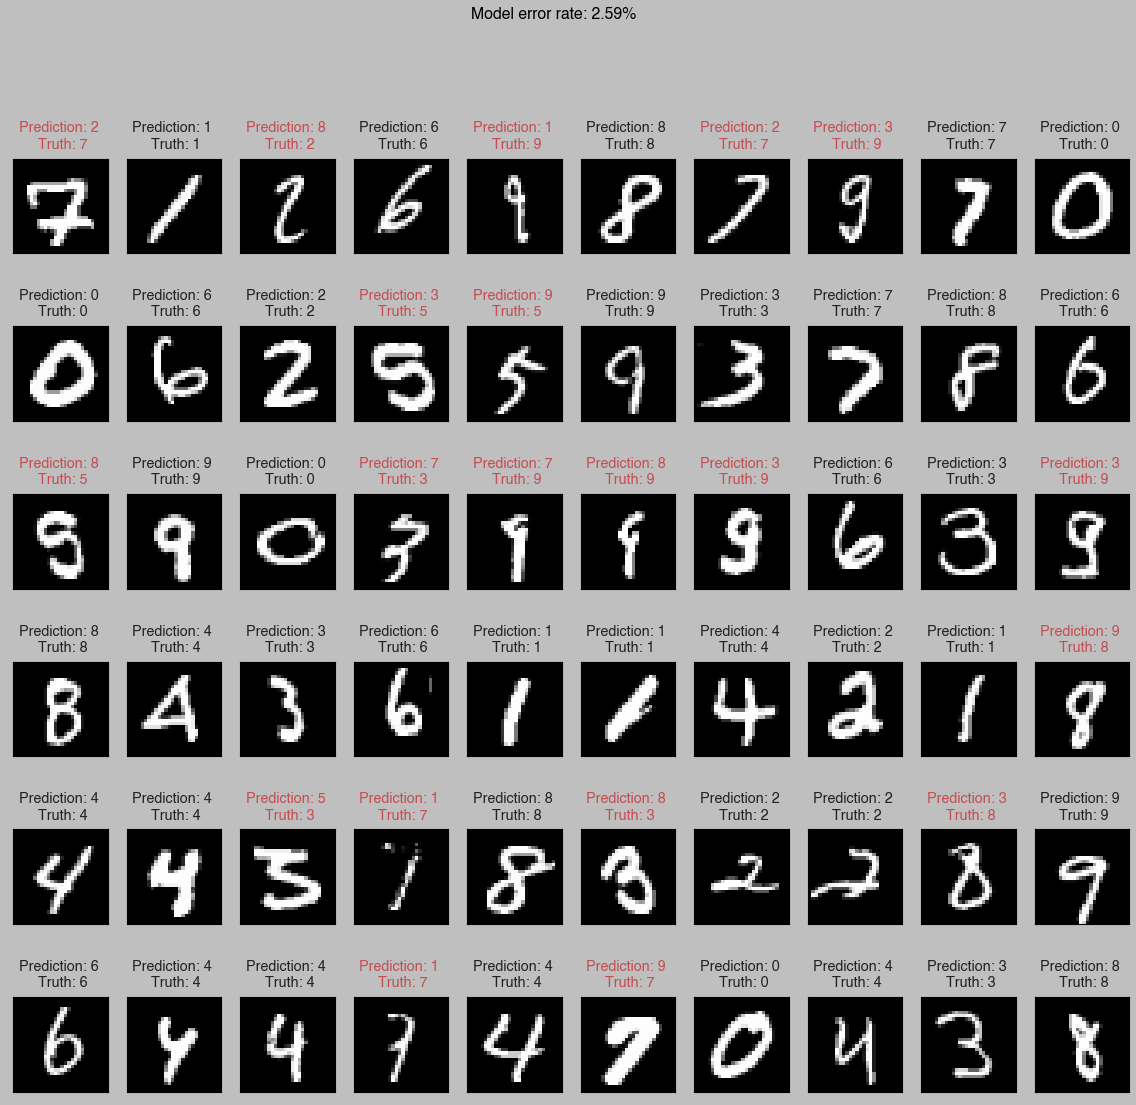

In [20]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_2layers.h5'))
show_test(model, (i_test, l_test))

# Enhanced MNIST
-------------------------------

<img src="Figures/data_augmentation.png" alt="drawing" width="800" >

You might have noticed that the performance on the training set saturated near 100%, which is usually a sign of overfitting. How can we address this situation, and improve the generalization capabilities of our network? One of the solutions is to apply to our stimulus set all the possible transformations it should be invariant to. As an example, for MNIST we have:
* Small translations
* Small rotations
* Elastic distortions

For the scope of this hands-on session we will enhance our stimulus set using only 1 pixel translations along the 4 cardinal directions (up, down, left, right). Also, to help reduce overfitting, we will add an $L_2$ weight regularization term to the cost function, which is defined as:
$$
C(a, y) = \mathcal{L}(a, y) \rightarrow C(a, y, \theta) = \mathcal{L}(a, y) + \frac{\lambda}{2n}|\theta|_2^2
$$
that is, for the cross-entropy,

$$
C(a, y) = \frac{1}{n}\sum_{x}\sum_{j} \left(y_j\log(a_j) + (1-y_j)\log(1-a_j)\right)
\rightarrow\\
C(a, y, \theta) = \frac{1}{n}\sum_{x}\sum_{j} \left(y_j\log(a_j) + (1-y_j)\log(1-a_j)\right) +
\frac{\lambda}{2n}|\theta|_2^2
$$

In [21]:
def enhance_mnist(i_train, l_train, transf = [(1, 0), (-1, 0), (0, 1), (0, -1)]):
    i_enhanced = []
    l_enhanced = []
    for i in tnrange(i_train.shape[0]):
        img = i_train[i, :, :, :]
        label = l_train[i, :]
        i_enhanced.append(img)
        l_enhanced.append(label)
        for shift in transf:
            x = np.pad(img, ((abs(shift[0]), abs(shift[0])),
                         (abs(shift[1]), abs(shift[1])), (0, 0)), 'constant')
            x = np.roll(x, shift, (0, 1))
            x = x[abs(shift[0]):(x.shape[0]-abs(shift[0])),
                  abs(shift[1]):(x.shape[1]-abs(shift[1])), :]
            i_enhanced.append(x)
            l_enhanced.append(label)
    i_enhanced = np.array(i_enhanced)
    l_enhanced = np.array(l_enhanced)
    perm_idx = np.random.permutation(i_enhanced.shape[0])
    return i_enhanced[perm_idx, :, :, :], l_enhanced[perm_idx, :]

In [22]:
i_enh, l_enh = enhance_mnist(i_train, l_train)

In [23]:
activation_fcn = 'relu'
lmbd = 0.01
learn_rate = 0.03
minibatch_size = 10
minimum_lr = 1e-5

In [24]:
K.clear_session()
regularization = regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               64100 

In [25]:
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_relu'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=minimum_lr, verbose=True)
h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (ReLU)'] = h.history
history['Convolutional (ReLU)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_relu.h5'))

Train on 250000 samples, validate on 10000 samples
Epoch 1/2
250000/250000 [==============================] - 442s 2ms/sample - loss: 0.3829 - accuracy: 0.9539 - val_loss: 0.2563 - val_accuracy: 0.9676
Epoch 2/2
250000/250000 [==============================] - 438s 2ms/sample - loss: 0.2595 - accuracy: 0.9661 - val_loss: 0.2083 - val_accuracy: 0.9808


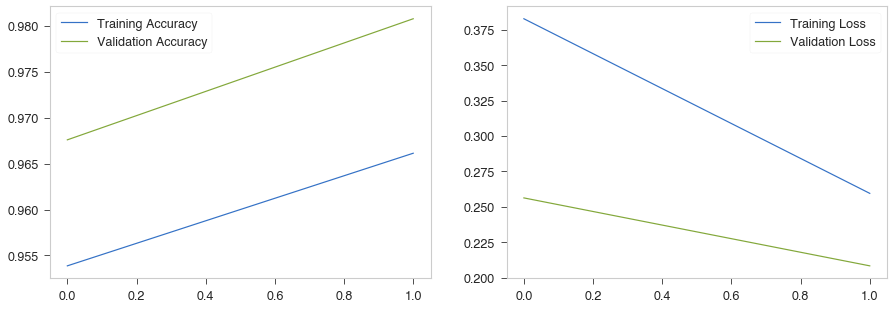

In [26]:
hist = history['Convolutional (ReLU)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['accuracy'])
ax[0].plot(hist['epoch'], hist['val_accuracy'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

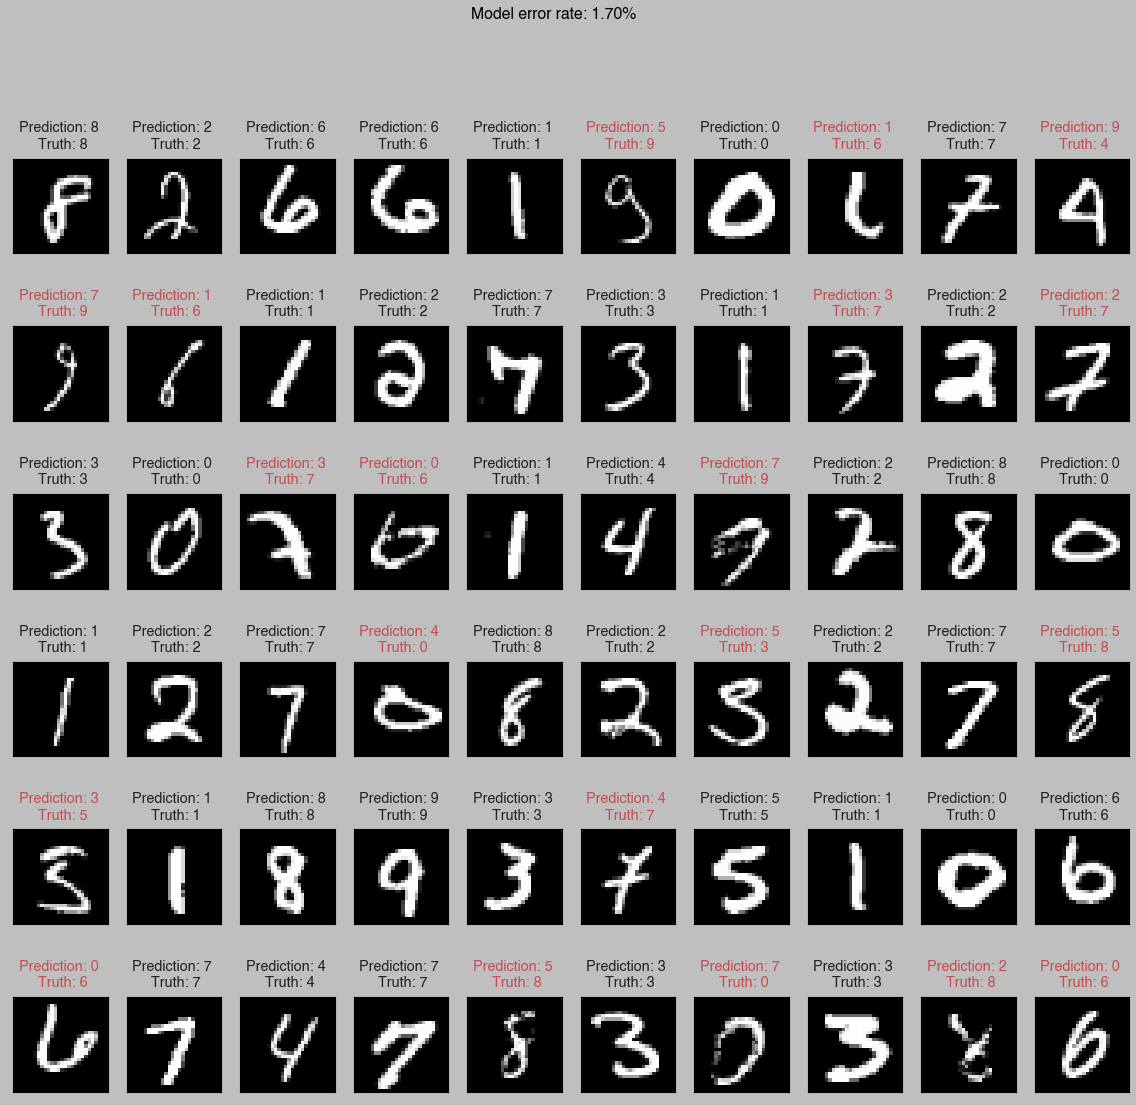

In [27]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_relu.h5'))
show_test(model, (i_test, l_test))

# Adding a dense layer
-------------------------------------

As a penultimate step we will add a second dense layer (this one too with 100 neurons) and see how this modification affects the performance

In [28]:
K.clear_session()
regularization = regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               64100 

In [29]:
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_2dense'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=minimum_lr, verbose=True)

h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (2 Dense Layers)'] = h.history
history['Convolutional (2 Dense Layers)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_2dense.h5'))

Train on 250000 samples, validate on 10000 samples
Epoch 1/2
250000/250000 [==============================] - 467s 2ms/sample - loss: 0.4949 - accuracy: 0.9480 - val_loss: 0.3176 - val_accuracy: 0.9694
Epoch 2/2
250000/250000 [==============================] - 439s 2ms/sample - loss: 0.3264 - accuracy: 0.9619 - val_loss: 0.2750 - val_accuracy: 0.9772


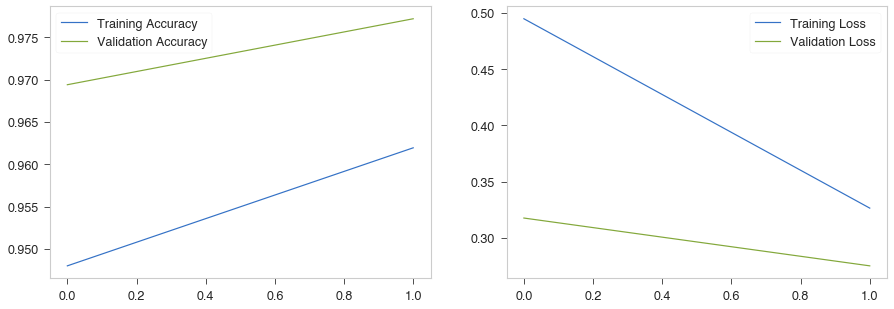

In [30]:
hist = history['Convolutional (2 Dense Layers)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['accuracy'])
ax[0].plot(hist['epoch'], hist['val_accuracy'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

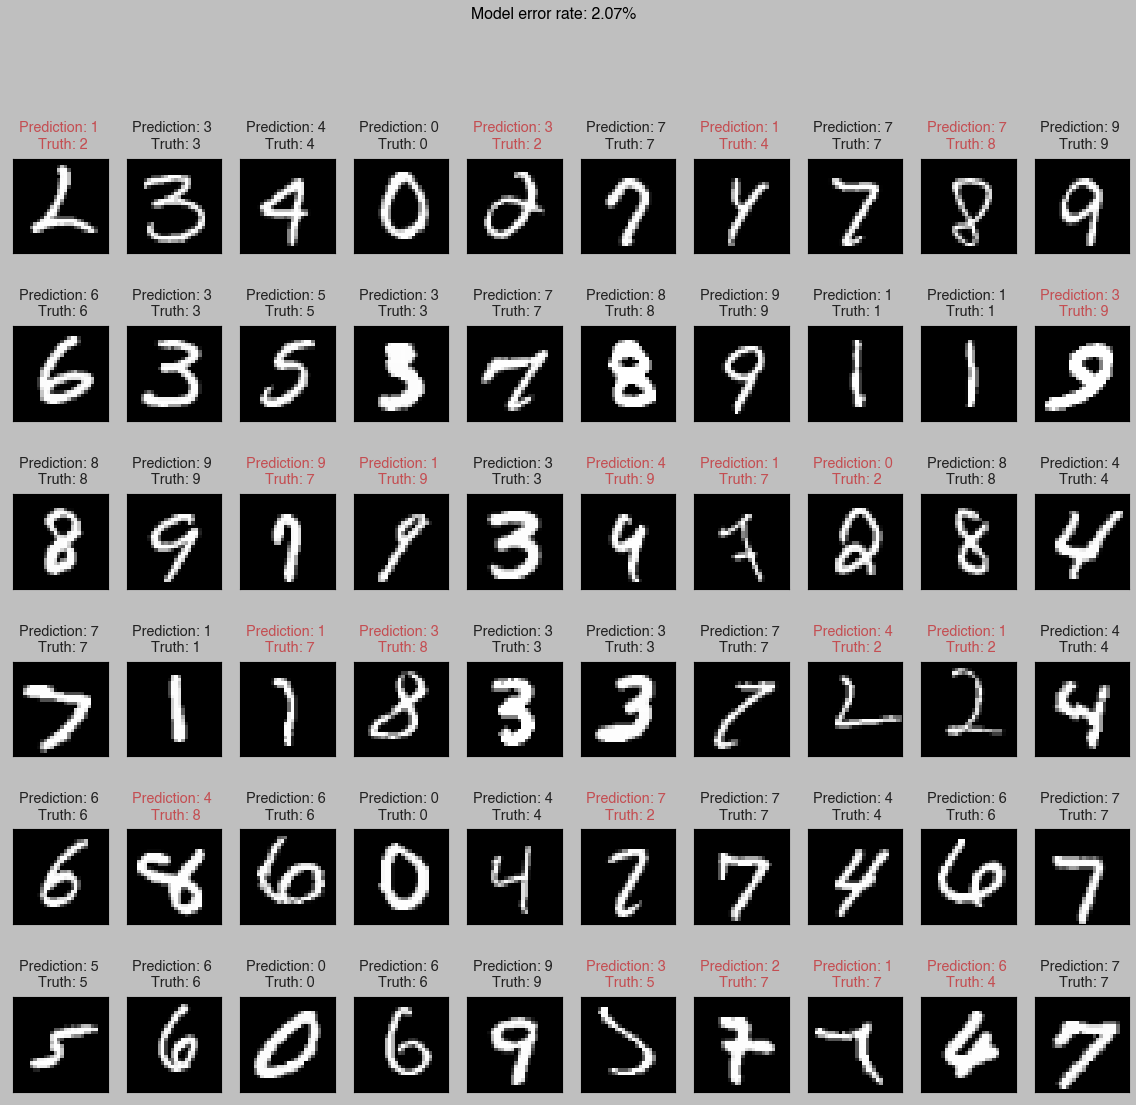

In [31]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_2dense.h5'))
show_test(model, (i_test, l_test))

# Dropout

<img src="Figures/dropout.png" alt="drawing" width="800" >

As we have seen, adding a second dense layer didn't do much good to the performance. Should we expand our dense layers? And if so, how can we avoid overfitting? To address this issue, we added dropout to the dense layers of our network. As you have seen yesterday, dropout is a regularization technique that removes the output of a random subset of neurons for each minibatch during training. This forces the network to rely on the presence of combinations of neurons rather than on the activations of a single, albeit very strong, unit, thus reducing overfitting. You could think dropout as the act of training several different networks, which will overfit in slightly different ways, and then averaging them together (thus reducing the magnitude of overfitting). Since dropout is a rather powerful regularization technique, we will omit the $L_2$ regularization term.

In [32]:
K.clear_session()
regularization = None#regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dropout (Dropout)            (None, 640)               0     

In [33]:
K.clear_session()
regularization = None#regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_dropout'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=minimum_lr, verbose=True)

h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (Dropout)'] = h.history
history['Convolutional (Dropout)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_dropout.h5'))

Train on 250000 samples, validate on 10000 samples
Epoch 1/2
250000/250000 [==============================] - 631s 3ms/sample - loss: 0.1676 - accuracy: 0.9468 - val_loss: 0.0376 - val_accuracy: 0.9890
Epoch 2/2
250000/250000 [==============================] - 619s 2ms/sample - loss: 0.0697 - accuracy: 0.9786 - val_loss: 0.0300 - val_accuracy: 0.9918


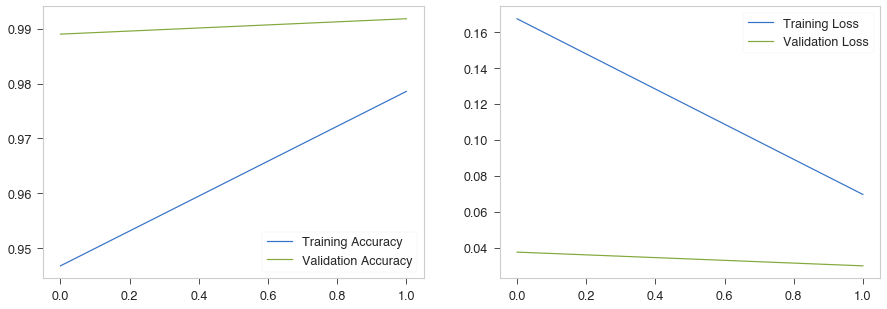

In [34]:
hist = history['Convolutional (Dropout)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['accuracy'])
ax[0].plot(hist['epoch'], hist['val_accuracy'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

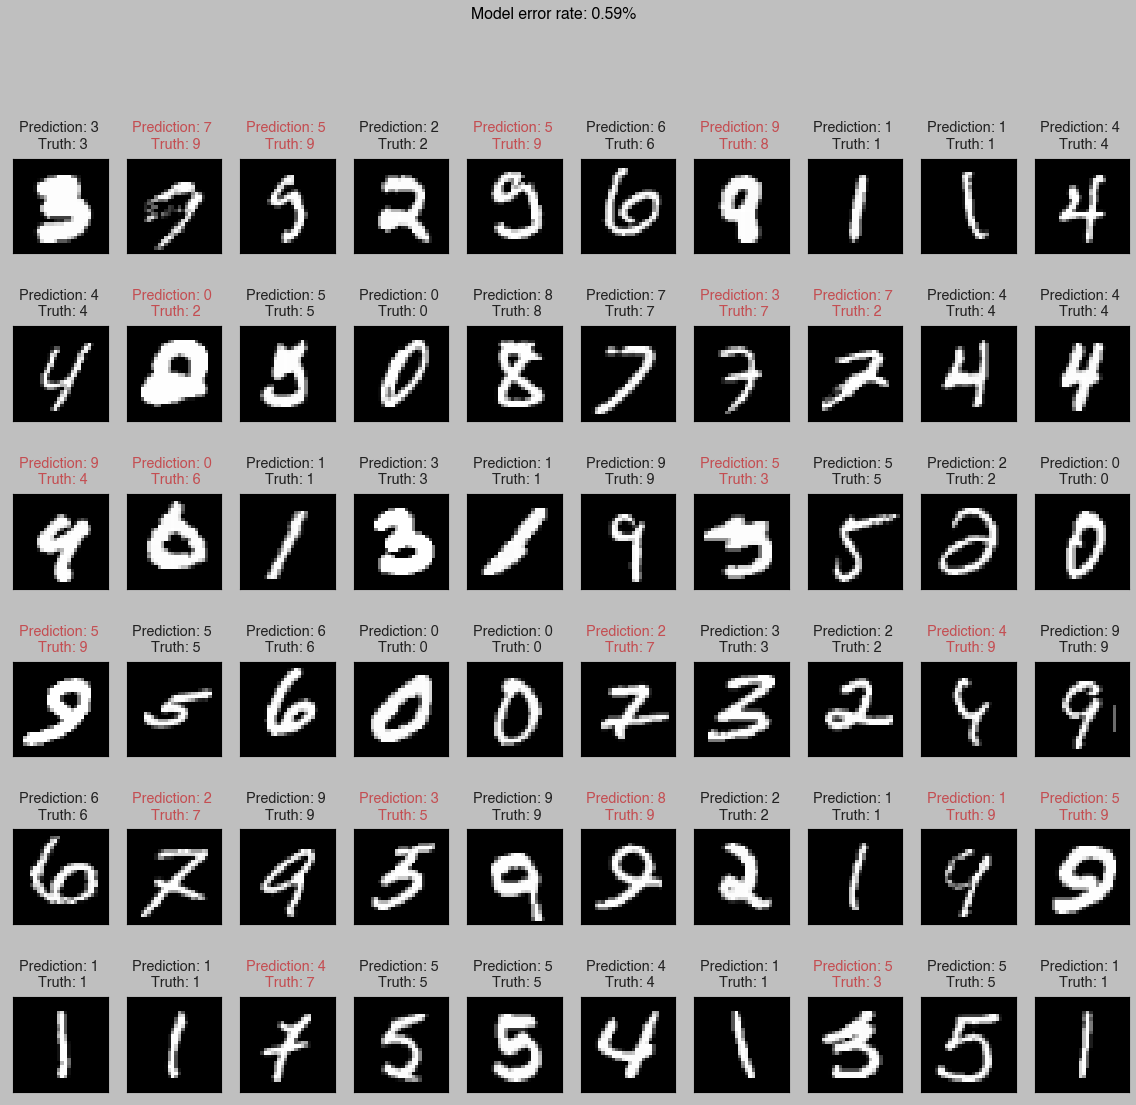

In [35]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_dropout.h5'))
K.set_learning_phase(0)
show_test(model, (i_test, l_test))

Summary Plots
=============

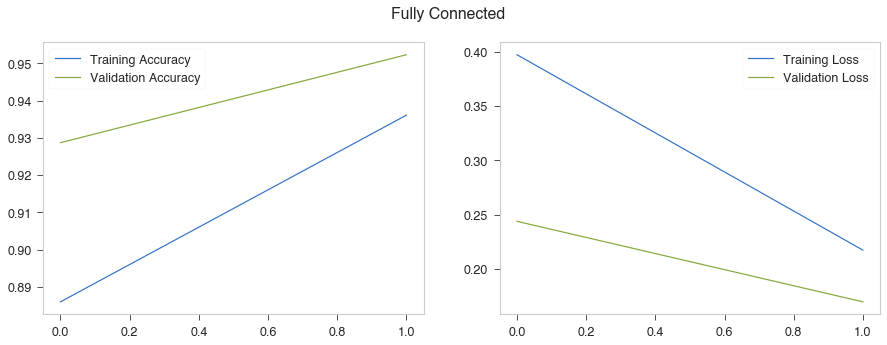

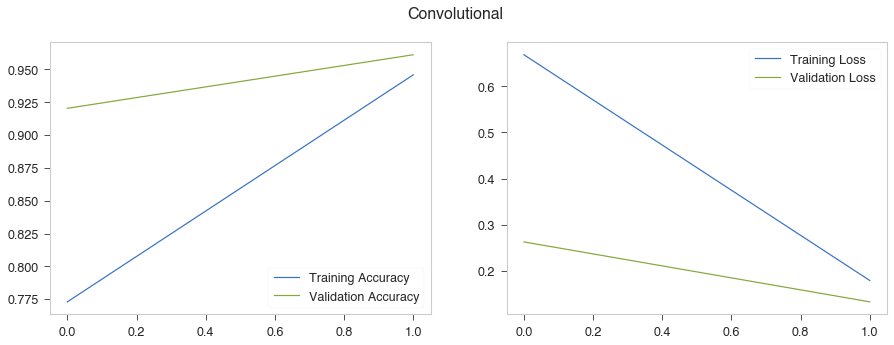

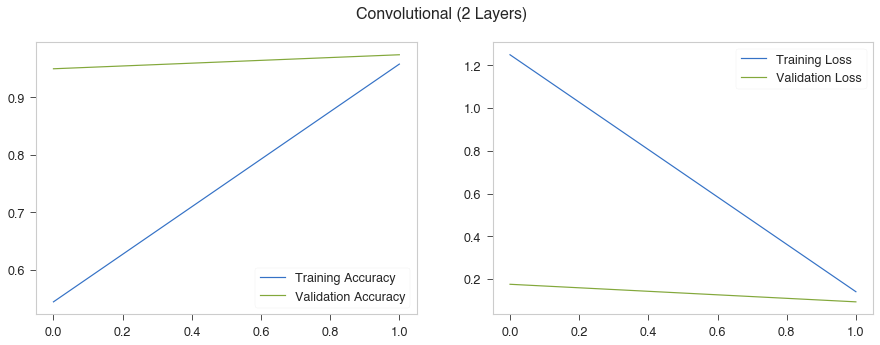

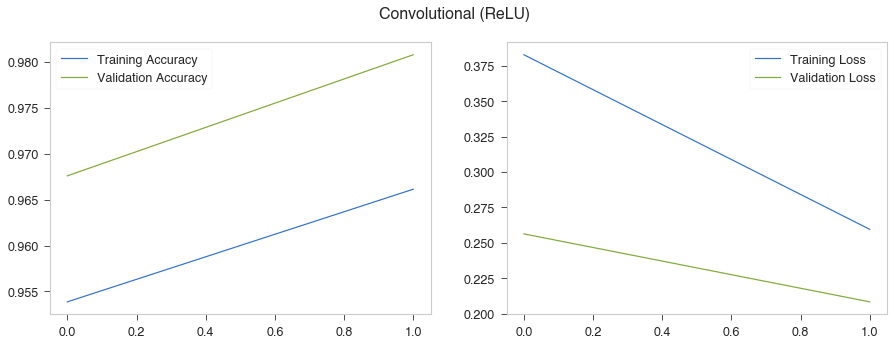

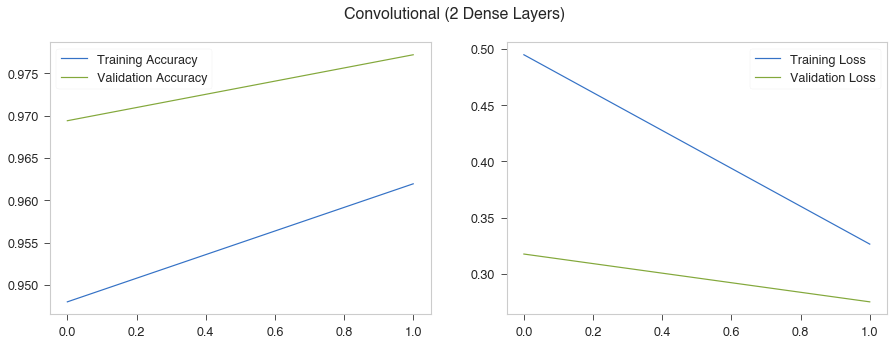

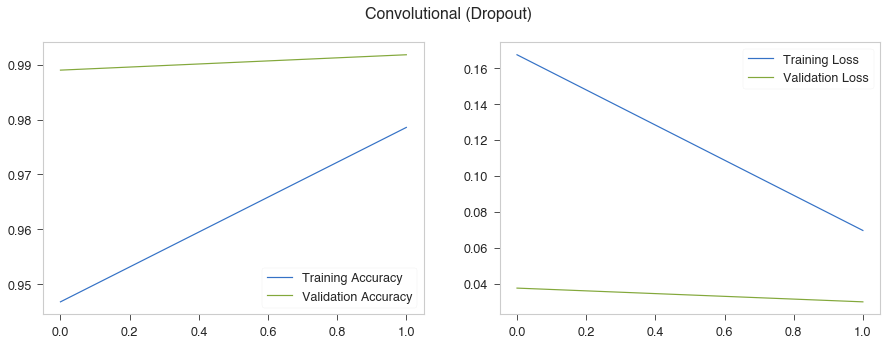

In [36]:
for name, hist in history.items():
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(hist['epoch'], hist['accuracy'])
    ax[0].plot(hist['epoch'], hist['val_accuracy'])
    ax[0].legend(['Training Accuracy','Validation Accuracy'])
    ax[1].plot(hist['epoch'], hist['loss'])
    ax[1].plot(hist['epoch'], hist['val_loss'])
    ax[1].legend(['Training Loss','Validation Loss'])
    fig.suptitle(name)
plt.show()

### Possible experimentations
-----------------------------------

- What does it happen when you change the minibatch size?
- Can you find a learning rate and minibatch size that speed up learning without losing (too much) performance?
- How do you add early stopping to the equation? (Hint: there's more than a way, check Keras documentation at https://keras.io)

In [37]:
with open(path.join('models', 'training_hist.pkl'), 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)